In [141]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gym 
from tqdm import tqdm 
from collections import deque
import seaborn as sns

In [127]:
class Node:
    def __init__(self, name, parent=None, mean=0, var=1, seed=2025):
        self.seed = seed
        self.rng =  np.random.RandomState(seed)
        self.name = name
        self.mean = mean  
        self.var = var  
        self.children = []
        self.scores_children = np.array([])
        self.nb_children = 0
        self.parent = parent
        self.level = parent.level + 1 if parent else 0
        self.value = self.get_reward()
    

    def get_child_nodes(self):
        if not nodes:
            nodes = []
        for child in self.children:
            nodes.append((child.name, child.level, child.nb_children))
            nodes.extend(child.get_child_nodes())
        return nodes

    def get_reward(self):
        return self.mean + np.sqrt(self.var) * self.rng.normal()



class Tree:
    def __init__(self, seed=2025):
        self.levels = [[]]
        self.graph = {'root': None,}
        self.max_level = 0
        self.seed = seed
        self.rng = np.random.RandomState(seed)

    def create_node(self, name, parent=None, mean=0, var=1):
        return Node(name, parent, mean, var, seed=self.seed)

    def insert(self, parent_node, name, mean, var):
        if parent_node is None:
            node = self.create_node(name, mean=mean, var=var)
            if node.level == 0:
                self.root = node
                value = node.get_reward()
                self.graph['root'] = node
            return node

        node = self.create_node(name, parent_node, mean, var)
        value = node.get_reward()
        self.graph[name] = node
        parent_node.children.append(node)
        parent_node.nb_children = len(parent_node.children)
        parent_node.scores_children = np.full(parent_node.nb_children, 1.0 / parent_node.nb_children)
        self.max_level = max(self.max_level, node.level)
        return node, parent_node

    def get_parent_nodes(self, node):
        nodes = [node]
        def _recursive_parent_nodes(node, nodes):
            if node.parent:
                nodes.append(node.parent)
                _recursive_parent_nodes(node.parent, nodes)
            return nodes
        nodes = _recursive_parent_nodes(node, nodes)
        nodes.reverse()
        return nodes

    def get_all_nodes(self):
        nodes = [self.root]
        def _get_nodes(node):
            for child in node.children:
                nodes.append(child)
                _get_nodes(child)
        _get_nodes(self.root)
        nodes = sorted(nodes, key=lambda node: node.level)
        nodes_names = [node.name for node in nodes]
        return nodes

    def get_all_leaves(self):
        leaves = []
        def get_leaves(node):
            if len(node.children) == 0:
                leaves.append(node)
            if node is not None:
                for child in node.children:
                    get_leaves(child)
        get_leaves(self.root)
        return leaves

    def get_reward_leaf(self, leaf):
        parents_leaf = self.get_parent_nodes(leaf)
        reward = 0 
        for node in parents_leaf:
            reward += node.value
        return reward
    
    def get_reward_leaves(self):
        leaves = self.get_all_leaves()
        data = []
        for leaf in leaves:
            data.append([leaf, leaf.name, self.get_reward_leaf(leaf)])
        return data


    def iterative_dfs(self, node_key=None):
        if not node_key:
            node_key = 'root'
        visited = []
        stack = deque()
        stack.append(node_key)
        while stack:
            node_key = stack.pop()
            if node_key not in visited:
                visited.append(node_key)
                unvisited = [n.name for n in self.graph[node_key].children if n.name not in visited]
                stack.extend(unvisited)
        return visited

    def iterative_bfs(self, start=None):
        if not start:
            start = 'root'
        visited = []
        queue = deque()
        queue.append(start)
        while queue:
            node_key = queue.popleft()
            if node_key not in visited:
                visited.append(node_key)
                unvisited = [n.name for n in self.graph[node_key].children if n.name not in visited]
                queue.extend(unvisited)
        return visited

    def find_best_arm_path(self):
        data = self.get_reward_leaves()
        best_leaf_index = np.argmax([x[2] for x in data])
        best_leaf, _, _ = data[best_leaf_index]
        path_nodes = self.get_parent_nodes(best_leaf)
        path_rewards = [node.value for node in path_nodes]
        path_names = [node.name for node in path_nodes]
        return path_nodes
    
    def visualize_tree(self):
        G = nx.DiGraph()
        labels = {}
        edge_labels = {}
        pos = {}
        node_colors = []

        def add_edges(node, pos_x=0, pos_y=0, layer_width=1.0):
            G.add_node(node.name)
            labels[node.name] = node.name
            pos[node.name] = (pos_x, -pos_y)
            node_colors.append(node.level)

            num_children = len(node.children)
            width_step = layer_width / max(num_children, 1)

            for i, child in enumerate(node.children):
                reward = child.value
                G.add_edge(node.name, child.name)
                edge_labels[(node.name, child.name)] = f"{reward:.2f}"

                child_x = pos_x - layer_width / 2 + (i + 0.5) * width_step
                add_edges(child, child_x, pos_y + 1, width_step)

        add_edges(self.root)
        for node in self.get_all_nodes():
            if len(node.children) == 0:  
                total_reward = self.get_reward_leaf(node)
                labels[node.name] = f"{node.name}\n({total_reward:.2f})"

        cmap = plt.cm.viridis
        colors = [cmap(l / (self.max_level + 1)) for l in node_colors]
        plt.figure(figsize=(14, 8))
        nx.draw(
            G, pos, labels=labels, node_color=colors,
            with_labels=True, node_size=2000, font_size=10, font_color='white'
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=self.max_level))
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
        cbar.ax.set_yticklabels([f"Level {i}" for i in range(self.max_level + 1)])
        plt.title("Environment")
        plt.axis('off')
        plt.show()

In [128]:
def generate_tree():
    tree = Tree()
    root = tree.insert(parent_node=None, name="Utilisateur", mean=0, var=0)

    # First Layer
    vehicule, _ = tree.insert(parent_node=root, name="vehicule", mean=0.8, var=2)
    mob_verte, _ = tree.insert(parent_node=root, name="Mobilités Vertes", mean=2, var=2)

    # Second Layer
    taxi, _ = tree.insert(parent_node=vehicule, name="taxi", mean=0.1, var=2)
    uber, _ = tree.insert(parent_node=vehicule, name="uber", mean=0.2, var=2)
    bus, _ = tree.insert(parent_node=vehicule, name="bus", mean=0.05, var=2)
    tram, _ = tree.insert(parent_node=vehicule, name="tram", mean=0.3, var=2)
    covoiturage, _ = tree.insert(parent_node=vehicule, name="covoiturage", mean=0.2, var=2)
    avion, _ = tree.insert(parent_node=vehicule, name="avion", mean=0.1, var=2)
    train, _ = tree.insert(parent_node=vehicule, name="train", mean=0.4, var=2)
    rer, _ = tree.insert(parent_node=vehicule, name="RER", mean=0.3, var=2)
    metro, _ = tree.insert(parent_node=vehicule, name="métro", mean=0.1, var=2)

    velo, _ = tree.insert(parent_node=mob_verte, name="vélo", mean=1.5, var=2)
    marche, _ = tree.insert(parent_node=mob_verte, name="marche", mean=1.0, var=2)
    cap, _ = tree.insert(parent_node=mob_verte, name="course à pied", mean=2.5, var=2)
    return tree

tree = generate_tree()

print("\n--- All the nodes in the Tree ---")
all_nodes = tree.get_all_nodes()
for node in all_nodes:
    print(f"Name: {node.name}, Drawing reward: {node.value:.4f}, Level: {node.level}")

print("\n--- Leaves of the Tree ---")
data = tree.get_reward_leaves()
for elements in data:
    name = elements[1]
    reward = elements[2]
    print(f"Name: {name}, Drawing reward: {reward:.4f}")

print("\n--- Path with the maximum reward ---")
best_path = tree.find_best_arm_path()
print(f"Max sum : {np.sum([node.value for node in best_path]):.4f}")
print(f"Rewards: {' -> '.join([str(node.value) for node in best_path])}")
print(f"Path: {' -> '.join([str(node.name) for node in best_path])}")


--- All the nodes in the Tree ---
Name: Utilisateur, Drawing reward: 0.0000, Level: 0
Name: vehicule, Drawing reward: 0.6693, Level: 1
Name: Mobilités Vertes, Drawing reward: 1.8693, Level: 1
Name: taxi, Drawing reward: -0.0307, Level: 2
Name: uber, Drawing reward: 0.0693, Level: 2
Name: bus, Drawing reward: -0.0807, Level: 2
Name: tram, Drawing reward: 0.1693, Level: 2
Name: covoiturage, Drawing reward: 0.0693, Level: 2
Name: avion, Drawing reward: -0.0307, Level: 2
Name: train, Drawing reward: 0.2693, Level: 2
Name: RER, Drawing reward: 0.1693, Level: 2
Name: métro, Drawing reward: -0.0307, Level: 2
Name: vélo, Drawing reward: 1.3693, Level: 2
Name: marche, Drawing reward: 0.8693, Level: 2
Name: course à pied, Drawing reward: 2.3693, Level: 2

--- Leaves of the Tree ---
Name: taxi, Drawing reward: 0.6387
Name: uber, Drawing reward: 0.7387
Name: bus, Drawing reward: 0.5887
Name: tram, Drawing reward: 0.8387
Name: covoiturage, Drawing reward: 0.7387
Name: avion, Drawing reward: 0.6387

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_8622/3986414435.py:183: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))


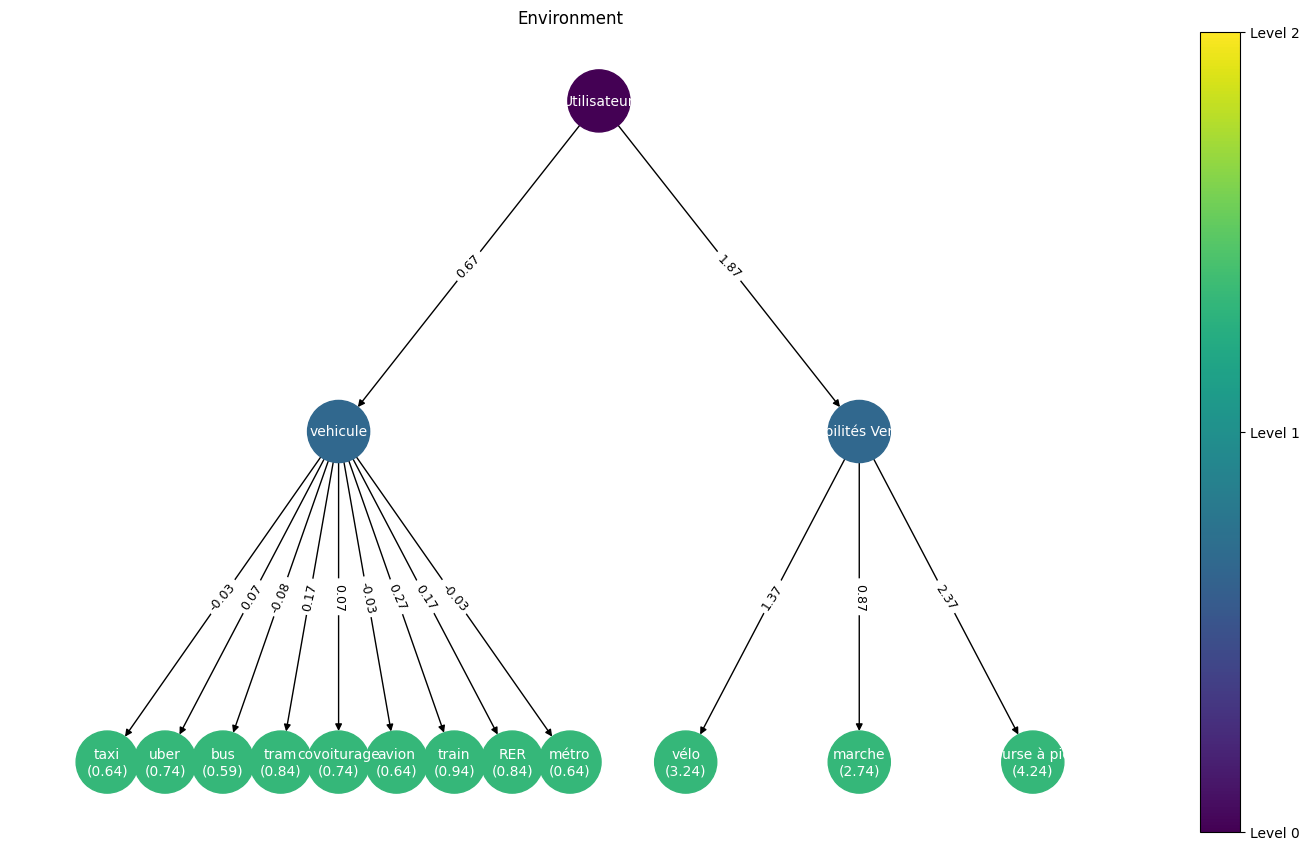

In [129]:
tree.visualize_tree()

In [ ]:
class StochasticEnvironment(gym.Env):
    def __init__(self, mus, seed=2025):
        self.mus = mus
        self.var = 2
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.generate_tree()
        
    def reset(self, seed):
        self.rng = np.random.RandomState(seed)
        tree = self.generate_tree()
        return tree
    
    def generate_tree(self):
        tree = Tree(seed=self.seed)
        var = 2
        root = tree.insert(parent_node=None, name="Utilisateur", mean=0, var=0)

        # First Layer
        mu_layer1 = self.mus[0]
        vehicule, _ = tree.insert(parent_node=root, name="vehicule", mean=mu_layer1[0], var=var)
        mob_verte, _ = tree.insert(parent_node=root, name="Mobilités Vertes", mean=mu_layer1[1], var=var)

        # Second Layer
        mu_layer2 = self.mus[1]
        mu_layer2_1 = mu_layer2[0]
        taxi, _ = tree.insert(parent_node=vehicule, name="taxi", mean=mu_layer2_1[0], var=var)
        uber, _ = tree.insert(parent_node=vehicule, name="uber", mean=mu_layer2_1[1], var=var)
        bus, _ = tree.insert(parent_node=vehicule, name="bus", mean=mu_layer2_1[2], var=var)
        tram, _ = tree.insert(parent_node=vehicule, name="tram", mean=mu_layer2_1[3], var=var)
        covoiturage, _ = tree.insert(parent_node=vehicule, name="covoiturage", mean=mu_layer2_1[4], var=var)
        avion, _ = tree.insert(parent_node=vehicule, name="avion", mean=mu_layer2_1[5], var=var)
        train, _ = tree.insert(parent_node=vehicule, name="train", mean=mu_layer2_1[6], var=var)
        rer, _ = tree.insert(parent_node=vehicule, name="RER", mean=mu_layer2_1[7], var=var)
        metro, _ = tree.insert(parent_node=vehicule, name="métro", mean=mu_layer2_1[8], var=var)

        mu_layer2_2 = mu_layer2[1]
        velo, _ = tree.insert(parent_node=mob_verte, name="vélo", mean=mu_layer2_2[0], var=var)
        marche, _ = tree.insert(parent_node=mob_verte, name="marche", mean=mu_layer2_2[1], var=var)
        cap, _ = tree.insert(parent_node=mob_verte, name="course à pied", mean=mu_layer2_2[2], var=var)
        
        self.tree = tree
        return tree
    
    
    def get_action_set(self):
        return self.tree.get_all_leaves()
    
    def sample_randomly(self):
        action_set = self.get_action_set()
        random_index = np.random.choice(len(action_set))
        leaf_chosen = action_set[random_index]
        return leaf_chosen

    def get_reward(self, leaf):
        return self.tree.get_reward_leaf(leaf)
    
    def get_total_reward_per_leaf(self):
        action_set = self.get_action_set()
        total_reward_per_leaf = [self.get_reward(leaf) for leaf in action_set]
        self.total_reward_per_leaf = total_reward_per_leaf
        return total_reward_per_leaf
    
    def get_best_strategy_reward(self):
        best_arm_path =  self.tree.find_best_arm_path()
        return [node.name for node in best_arm_path] ,np.sum([node.value for node in best_arm_path])
    
    def get_gap(self, leaf):
        total_reward_per_leaf = self.get_total_reward_per_leaf()
        reward_leaf = self.get_reward(leaf)
        means = self.get_means()
        reward_mean = leaf.mean
        #return max(means) - reward_mean  #pseudo-regret
        return max(total_reward_per_leaf) - reward_leaf  #regret
    
    def get_means(self):
        return list(np.array(self.mus[0][0]) + np.array(self.mus[1][0])) + list(np.array(self.mus[0][1]) + np.array(self.mus[1][1]))

    def step(self, leaf):
        reward = self.get_reward_leaf(leaf)
        done = True  
        return [0], reward, done, {}
    
    def render(self, mode='human', close=False):
        pass

In [131]:
mus = [ 
    [0.3, 2.6], # Layer 1
    [[0.1, 0.15, 0.05, 0.3, 0.2, 0.09, 0.2, 0.4, 0.3], [1.5, 2, 2.5]] # Layer 2
]
env = StochasticEnvironment(mus)
tree = env.reset()
leaf = env.sample_randomly()
path, reward = env.get_best_strategy_reward()
print(f"Best reward is: {reward}, you have to do {path}")
env.get_reward(leaf)

Best reward is: 4.838681116351248, you have to do ['Utilisateur', 'Mobilités Vertes', 'course à pied']


0.1386811163512481

In [210]:
# Small constant to prevent division by zero errors
EPS = 1e-8

class NestedExponentialWeights:
    """
    A class implementing the Nested Exponential Weights (NEWE) algorithm for decision-making
    in environments with rewards and losses over a series of rounds.

    This algorithm is designed for settings where an agent must make sequential decisions 
    from a set of actions, each of which may depend on previously chosen actions (e.g., tree-based models).
    """

    def __init__(self, environment):
        self.environment = environment
        self.action_set = self.environment.get_action_set()
        self.K = len(self.action_set)
        self.reset()
             

    def reset(self, seed=2025):
        self.rng = np.random.RandomState(seed) 
        self.rewards = []
        self.rounds = 0 
        self.cumulative_regret = []  
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)

    def get_index_leaf(self, leaf):
        name = leaf.name
        liste_name = [node.name for node in self.action_set]
        return liste_name.index(name)

    def vector_proba(self, y):
        stable_exp_y = np.exp(y - np.max(y))
        proba_vector = stable_exp_y/np.sum(stable_exp_y)
        return proba_vector
    
    def receive_reward(self, reward):
        self.rewards.append(reward)
        _, best_possible_reward = self.environment.get_best_strategy_reward()
        self.cumulative_regret.append(best_possible_reward-reward)
        index = self.get_index_leaf(leaf)
        self.count_actions[index] += 1
        self.count_rewards += reward
        self.rounds += 1

    def get_action(self, round):
        nodes_path = []  # Path of nodes chosen
        proba_path = []  # Corresponding probabilities for each node
        reward_path = []  # Corresponding rewards for each node
        node_path = [] # Each node
        node = self.environment.tree.root  # Start from the root node

        while bool(node.children):  # Continue as long as the current node has children
            node_path.append(node)
            lr = 1 / np.sqrt(round + 1)  # Learning rate decreases over time
            proba = self.vector_proba(node.scores_children * lr)  # Get probabilities using softmax
            idx_list = range(node.nb_children)  # List of child indices
            idx_node = self.rng.choice(idx_list, p=proba)  # Sample a child based on the probabilities
            child_node = node.children[idx_node]  # Select the chosen child
            nodes_path.append(idx_node)  # Append the index to the path
            reward_child = node.value  # Get reward for the chosen child
            reward_path.append(reward_child)  # Append the reward
            proba_path.append(proba[idx_node])  # Append the probability
            node = child_node  # Move to the child node for the next iteration
        self.update_score(nodes_path, proba_path, reward_path)
        return node

    def update_score(self, nodes_path, proba_path, reward_path):
        node = self.environment.tree.root  # Start from the root node
        proba = 1  # Initial probability is 1

        # Iterate through the nodes in the path, updating scores based on rewards
        for idx_node, P, reward in zip(nodes_path, proba_path, reward_path):
            proba *= P  # Update the joint probability
            node.scores_children[idx_node] = node.scores_children[idx_node] + reward / (proba + EPS)
            node = node.children[idx_node]  # Move to the next node in the path
    
    def name(self):
      return 'NEW' 

In [191]:
class UCB:
  def __init__(self, environment):
        self.environment = environment
        self.action_set = self.environment.get_action_set()
        self.K = len(self.action_set)
        self.reset(seed=2025)       

  def reset(self, seed=2025):
      self.rng = np.random.RandomState(seed) 
      self.rewards = []
      self.t = 0 
      self.cumulative_regret = []  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
  
  def get_action(self):
    if self.t < self.K:
        action = self.t
    else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions) 
        action = np.argmax(empirical_means + ucbs)

    self.t += 1
    self.count_actions[action] += 1
    self.current_action = action #need to remember the *index* of the action now
    return self.action_set[action]

  def receive_reward(self, reward):
    self.count_rewards[self.current_action] += reward

  def compute_condition(self):
    empirical_means = self.count_rewards / self.count_actions
    star_hat = np.argmax(empirical_means)
    mu_star_hat = empirical_means[star_hat]
    N_star = self.count_actions[star_hat]
    inv_N_star = 1 / N_star
    inf = np.min([((mu_star_hat - empirical_means[k])**2)/(inv_N_star + (1/self.count_actions[k])) for k in list(range(self.K)) if k!=star_hat])
    return inf

  def name(self):
    return 'UCB' 

In [238]:
def play(environment, agent, Nmc, T):
    """
    Simulate multiple trajectories of agent-environment interaction and record regret.

    This function simulates the interaction between a single agent and an environment 
    over Nmc independent trajectories, each lasting T rounds. It records the pseudo-regret 
    at each time step by comparing the received reward to the best possible reward.

    Parameters
    ----------
    environment : object
        The environment in which the agent operates. 

    agent : object
        The agent being evaluated. 

    Nmc : int
        Number of Monte Carlo trajectories to simulate.

    T : int
        Time horizon (number of steps per trajectory).

    Returns
    -------
    agent_id : str
        The name or identifier of the agent (via `agent.name()`).

    data : np.ndarray
        A NumPy array of shape (Nmc, T), where each entry contains the pseudo-regret 
        (best possible reward minus received reward) at time t in trajectory n.

    Notes
    -----
    The pseudo-regret at each time step is computed using the current mean rewards
    of the environment arms, which assumes those are fixed and known for evaluation.
    """
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))
    for episode in tqdm(range(Nmc)):
        tree = environment.reset(seed=episode)  
        agent.reset(seed=episode)   
        #print("Best strategy: \n")   
        #print(environment.get_best_strategy_reward())
        for t in range(T):
            action_set = environment.get_action_set()
            if agent.name() == 'NEW':
                leaf = agent.get_action(t)
            else:
                leaf = agent.get_action()
            print(f"At time {t}, {agent.name()} chooses {leaf.name}")
            # Get reward for the chosen action and send it back to the agent
            reward = environment.get_reward(leaf)
            agent.receive_reward(reward)
            
            # Compute pseudo-regret: best mean - received reward
            means = environment.get_means()
            best_reward = np.max(means)
            data[episode, t] = env.get_gap(leaf)   #best_reward - reward
    return agent.name(), data


In [194]:
def experiment(environment, agents, Nmc, T):
    """
    Run multiple simulations of each agent interacting with the environment and record regret.

    This function evaluates a list of agents by having them interact with a given environment
    over multiple Monte Carlo simulations, each lasting for a fixed time horizon.
    For each agent, it computes and stores the regret over time for each trajectory.

    Parameters
    ----------
    environment : object
        The environment in which the agents operate. 
    
    agents : list
        A list of agent instances. Each agent must implement `reset()`, `get_action()`,
        `receive_reward(action, reward)`, and `name()` methods.
    
    Nmc : int
        Number of Monte Carlo simulations to run for each agent.
    
    T : int
        Time horizon (number of rounds) for each simulation.

    Returns
    -------
    all_data : dict
        A dictionary mapping each agent's name (str) to a NumPy array of shape (Nmc, T),
        containing the regret at each time step for each Monte Carlo run.
    """
    all_data = {}

    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)

        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

In [236]:
def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None):
    """
    regrets must be a dict {'agent_id':regret_table}
    """
    colors = sns.color_palette('colorblind')
    reg_plot = plt.figure()

    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))
    sqrt = [np.sqrt(t) for t in range(T)]
    plt.plot(np.arange(T), sqrt, label="racine", color = "red", alpha=0.3)
    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_8622/4076917951.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


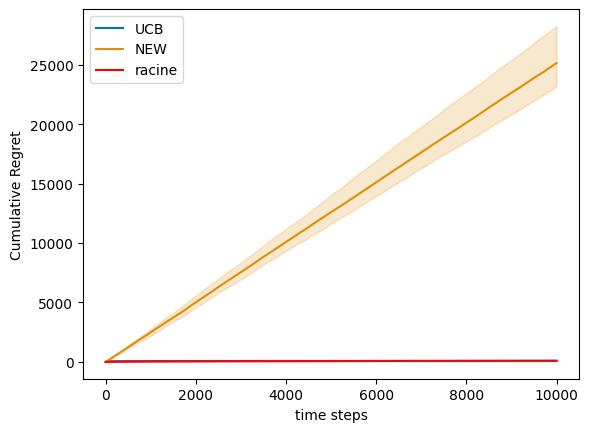

In [233]:
T = 10000  # Finite Horizon
N = 10  # Monte Carlo simulations
q = 10  #choice of percentile display
mus = [ 
    [0.3, 2.6], # Layer 1
    [[0.1, 0.15, 0.05, 0.3, 0.2, 0.09, 0.2, 0.4, 0.3], [1.5, 2, 2.5]] # Layer 2
]

# Framework for the experiments
env = StochasticEnvironment(mus)

# Initialization of the agents
new = NestedExponentialWeights(environment=env)
ucb = UCB(environment=env)

# Run experiments
all_data = experiment(env, [ucb, new], Nmc=N, T=T)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_8622/3903267600.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


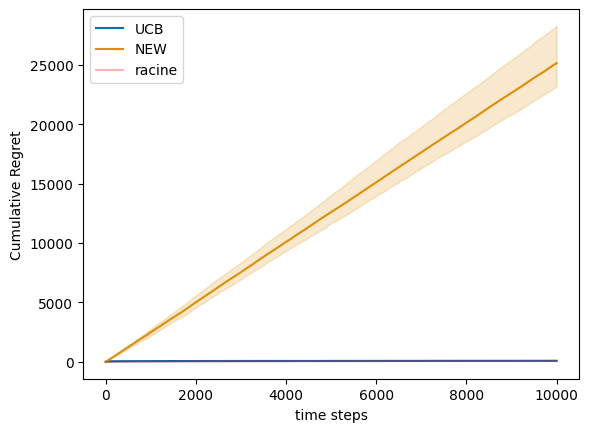

In [237]:
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)

In [240]:
T = 10000  # Finite Horizon
N = 1  # Monte Carlo simulations
q = 10  #choice of percentile display
all_data = experiment(env, [ucb], Nmc=N, T=T)

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

At time 0, UCB chooses taxi
At time 1, UCB chooses uber
At time 2, UCB chooses bus
At time 3, UCB chooses tram
At time 4, UCB chooses covoiturage
At time 5, UCB chooses avion
At time 6, UCB chooses train
At time 7, UCB chooses RER
At time 8, UCB chooses métro
At time 9, UCB chooses vélo
At time 10, UCB chooses marche
At time 11, UCB chooses course à pied
At time 12, UCB chooses course à pied
At time 13, UCB chooses marche
At time 14, UCB chooses course à pied
At time 15, UCB chooses course à pied
At time 16, UCB chooses vélo
At time 17, UCB chooses course à pied
At time 18, UCB chooses marche
At time 19, UCB chooses course à pied
At time 20, UCB chooses course à pied
At time 21, UCB chooses course à pied
At time 22, UCB chooses marche
At time 23, UCB chooses course à pied
At time 24, UCB chooses course à pied
At time 25, UCB chooses course à pied
At time 26, UCB chooses vélo
At time 27, UCB chooses marche
At time 28, UCB chooses course à pied
At time 29, UCB chooses course à pied
At ti

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_8622/3903267600.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


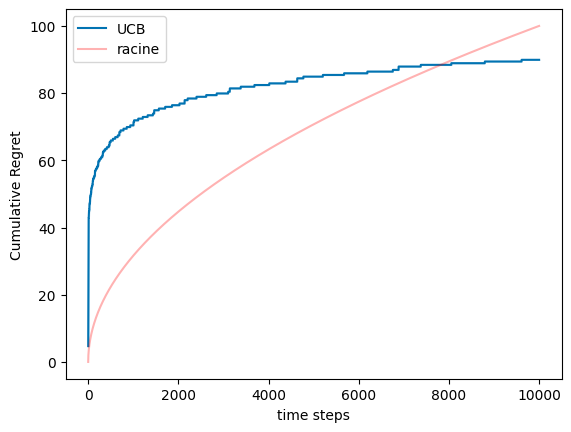

In [241]:
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)